### Sapienza Università di Roma - Big Data for Official Statistics
#### Autore: Mascolo Davide, 2001991

In questo notebook, sono stati utilizzati Keras e Tensorflow per implementare architetture di reti neurali convoluzionali (CNN), come EfficientNetB0, ResNet50, e VGG16, utilizzando la tecnica del Transfer Learning per rilevare e classificare tre tipi di tumori cerebrali vale a dire - Glioma, Meningioma e Pituitario.

Inoltre, sono state implementate due Convolutional Neural Networks from scratch le cui performance sono confrontate con le reti pre-trained.

Il set di dati utilizzato consiste in 3264 immagini di risonanze magnetiche  in 2-D e rappresentanti 4 classi. Diverse tecniche di data augmentation sono state applicate per aumentare il numero di immagini durante il training.

In [ ]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.8 MB/s 


In [ ]:
## Import utils
from google.colab import drive
import os
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import tensorflow_addons as tfa
from sklearn.utils import shuffle
from PIL import Image
import imutils
import timeit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [ ]:
# Select GPU device
device = tf.test.gpu_device_name()
print("Current device", device)

Current device /device:GPU:0


In [ ]:
## Set seed
tf.random.set_seed(1234)

In [ ]:
## Mount drive
drive.mount("/content/drive/", force_remount = True)

Mounted at /content/drive/


### Caricamento dei dati

In questa sezione è stata implementata una funzione per importare le immagini dal drive.

In [ ]:
## Define paths to take data from folders and labels
path_train = ("/content/drive/My Drive/Secondo Anno/SMOS/Data/Training/")
path_test  = ("/content/drive/My Drive/Secondo Anno/SMOS/Data/Testing/")
labels     = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

## Resize the images
image_size = 150

## Define empty lists in which to save data
X_train = []
y_train = []

X_test  = []
y_test  = []

## Implement a function to import data
def import_data(X, y, path, image_size, labels):
    """Input: X          --> data
              y          --> target variable
              image_size --> size of the image
              labels     --> a list of strings for target variable
       Output:
              X --> features
              y --> target variable
    """
    ## Iteration
    for i in labels:
        folderPath = os.path.join(path, i)
        num_classes = labels.index(i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.resize(cv2.imread(os.path.join(folderPath, j)),
                             (image_size, image_size))
            img = cv2.GaussianBlur(img, (5,5), 0)
            X.append(img)
            y.append(i)

    print("---------")
    print("Finish...")

In [ ]:
## Training Data
import_data(X_train, y_train, path_train, image_size, labels)
## Test Data used for building the training data
import_data(X_train, y_train, path_test, image_size, labels)

## Organize into numpy array
## Training
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 827/827 [00:14<00:00, 56.25it/s] 


---------
Finish...


100%|██████████| 74/74 [00:18<00:00,  3.98it/s]


---------
Finish...


In [ ]:
## Check
print("Train shape", X_train.shape)

Train shape (3264, 150, 150, 3)


In [ ]:
## Shuffle data
X_train, y_train = shuffle(X_train, y_train, random_state = 50)

In [ ]:
## Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.1, random_state = 50)

In [ ]:
## Check
print("Train shape", X_train.shape)
print("-----------------------------")
print("Test shape", X_test.shape)
print("-----------------------------")
print("Y train shape", y_train.shape)
print("-----------------------------")
print("Y Test shape", y_test.shape)

Train shape (2937, 150, 150, 3)
-----------------------------
Test shape (327, 150, 150, 3)
-----------------------------
Y train shape (2937,)
-----------------------------
Y Test shape (327,)


### EDA

Per la fase di analisi esplorativa, visualizziamo un sample casuale per ogni categoria della variabile dipendente.

In [ ]:
# Look the data
def image_show(data, y):
    """Input: Dataset, target variable
       Output: Plot one image for each class"""
    k = 0
    fig, ax = plt.subplots(1,4,figsize = (20, 22))
    fig.text(s = "Sample Image for each class", size = 18,
             fontweight = "bold", fontname = "monospace" , y = 0.62, x = 0.4, alpha = 0.8)
    for i in labels:
        j = 0
        while True :
            if y[j] == i:
                ax[k].imshow(data[j])
                ax[k].set_title(y[j])
                ax[k].axis("off")
                k += 1
                break
            j+=1

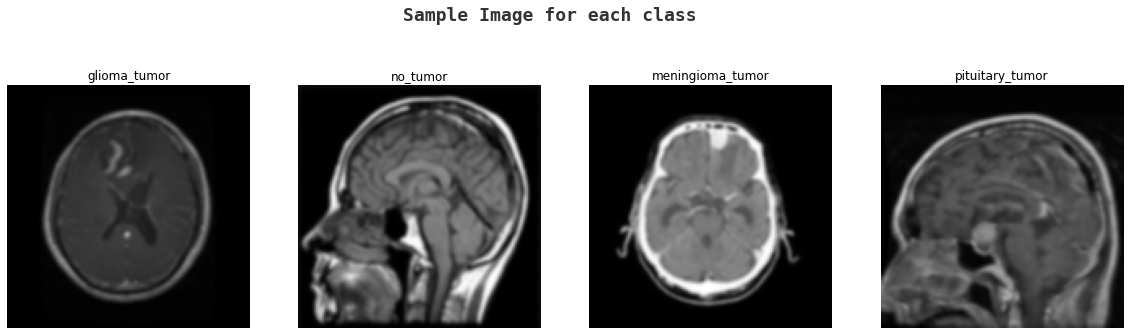

In [ ]:
## Training samples
image_show(X_train, y_train)

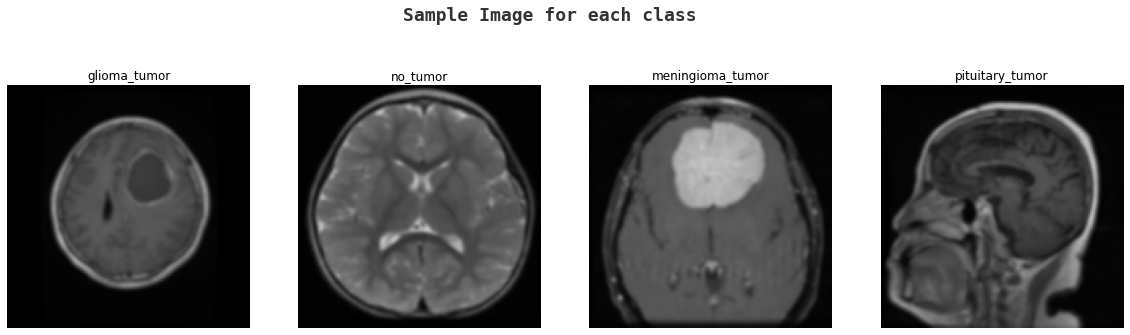

In [ ]:
## Testing samples
image_show(X_test, y_test)

Nel plot che segue, è possibile osservare la distribuzione della variabile dipendente per il training set e per il test set.



In [ ]:
## Preparing plot

## Training
(Tumor_train, Count_train) = np.unique(y_train, return_counts = True)
res_train = {x:y for x, y in zip(Tumor_train, Count_train)}

## Test
(Tumor_test, Count_test) = np.unique(y_test, return_counts = True)
res_test = {x:y for x, y in zip(Tumor_test, Count_test)}

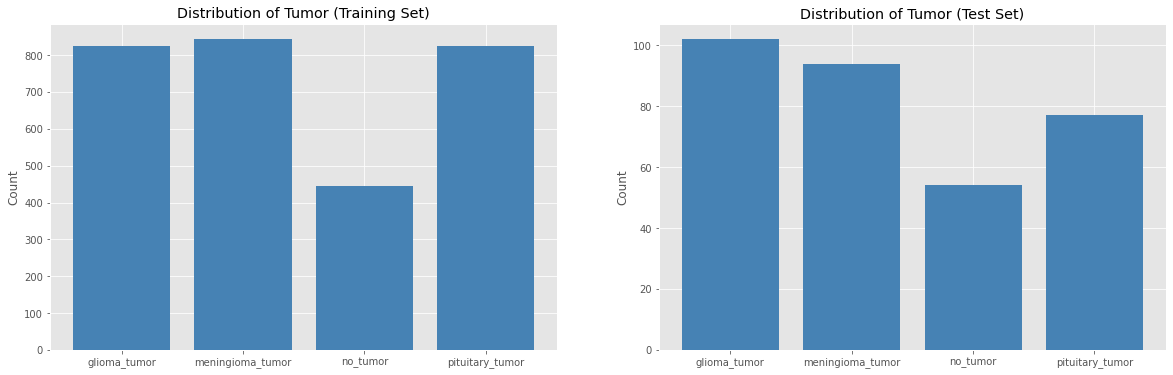

In [ ]:
## Plot
plt.style.use("ggplot")

## Training
plt.figure(figsize = (20, 6))
plt.subplot(121)
plt.bar(range(len(res_train)), list(res_train.values()), align = "center", color = "steelblue")
plt.title("Distribution of Tumor (Training Set)")
plt.ylabel("Count")
plt.xticks(range(len(res_train)), list(res_train.keys()))

## Test
plt.subplot(122)
plt.bar(range(len(res_test)), list(res_test.values()), align = "center", color = "steelblue")
plt.title("Distribution of Tumor (Test Set)")
plt.ylabel("Count")
plt.xticks(range(len(res_test)), list(res_test.keys()))

plt.show()

Dopo la fase di visualizzazione dei dati, si passa al trattamento di essi prima di arrivare alla classificazione.

In particolare, sono stati svolti i seguenti passaggi:

1. **Resize dell'immagine**:
Tutte le immagini sono state ridimensionate in una size di 150x150.

2.  **Noise Reduction**:
L'operatore di smoothing gaussiano è un operatore di convoluzione 2D che viene utilizzato per "sfocare" le immagini e rimuovere dettagli e rumore.

3. **Data Augmentation**:
Tecnica di regolarizzazione utilizzata per rendere più robusto il modello e quindi evitare l'overfitting. In questo caso, si generano nuove immagini a partire dal training set che saranno date in input durante la fase di addestramento.

Le trasformazioni applicate sulle immagini sono le seguenti:

- Rescale

- Rotazione con un angolo di 30 gradi

- Shift vertical ed orizzontale

- Zoom

- Specchiare l'immagine in orizzontale

4. **One-Hot Encoding** per la variabile dipendente.

In [ ]:
## Data Augmentation
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1. / 255,        ## rescale the images
    rotation_range = 30,       ## rotation images
    width_shift_range = 0.05,  ## width shift
    height_shift_range = 0.05, ## height shift
    zoom_range = 0.1,          ## zoom images
    horizontal_flip = True)    ## horizontal flip

In [ ]:
# Apply data augmentation only on the training set
data_gen.fit(X_train)

In [ ]:
## One-hot Encoding for the target variable
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

### Modelli

Per la fase di modelli, si inizia con l'implementazione di una Convolutional Neural Network che è utilizzata come metro di paragone per i successivi modelli.

#### Convolutional Neural Network (Version 1)

La rete definita di seguito è composta da 5 strati totali, compresi lo strato in input ed output. Ogni strato è composto da:
- Convoluzione 2D
- Max Pooling 2D
- Batch Normalization
- Dropout

Lo strato finale (Fully Connected Layer) è composto da 128 neuroni collegati ai 4 neuroni di uscita (uno per ogni classe da prevedere) e gestiti dalla funzione softamx.

In [ ]:
## Define the CNN model
model_cnn = tf.keras.Sequential([
    ## First layer
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (5, 5), activation = "relu", padding = "same"), ## Convolution 2D
    tf.keras.layers.MaxPool2D(2,2),       ## Max pooling
    tf.keras.layers.BatchNormalization(), ## Batch Normalization
    tf.keras.layers.Dropout(0.2),         ## Dropout

    ## Second layer
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = "same"),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    ## Third layer
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = "same"), 
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2), 

    ## Fourth layer
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (2, 2), activation = "relu", padding = "same"), 
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2), 

    ## Output layer
    tf.keras.layers.Flatten(),                       ## add flatten
    tf.keras.layers.Dense(128, activation = "relu"), ## fully connected layer
    tf.keras.layers.Dropout(rate = 0.3),             ## dropout 
    tf.keras.layers.Dense(4, activation = "softmax") ## softmax
])

Per compilare il modello, si definiscono i seguenti iperparametri:
- Batch size
- Numero di epoche

Inoltre, non viene utilizzato il modello all'ultima epoca, ma ogni 2 epoche si fa un checkpoint della *validation loss*; se essa non decresce si riduce il valore del learning rate e si procede con l'addestramento, in modo da garantire la convergenza del gradiente e salvare il modello che minimizza la validation loss.

Le metriche di riferimento sono:
- Accuracy
- Recall
- Precision
- F1 Score

In [ ]:
## Set hyperparameters
batch_size    = 32
epochs        = 15
num_classes   = len(labels)

## Save the best model
checkpoint  = tf.keras.callbacks.ModelCheckpoint("cnn_1.h5", monitor = "val_loss", save_best_only = True, mode = "auto", verbose = 1)
reduce_lr   = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.3, patience = 2, min_delta = 0.001,
                                                   mode = "auto", verbose = 1)

## Define metrics
recall    = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
f1_score  = tfa.metrics.F1Score(num_classes = num_classes,
                                threshold = 0.5)

metrics   = ["accuracy", precision, recall, f1_score]

Tutti i modelli sono stati compilati utilizzando la *categorical cross entropy* come funzione di loss ed *adam* come optimizer.

In [ ]:
## Compile the model
model_cnn.compile(loss = "categorical_crossentropy",
                  optimizer = "adam",
                  metrics = metrics)

In [ ]:
## Training CNN
start = timeit.default_timer()

## Fit
history_cnn = model_cnn.fit(tf.cast(X_train, tf.float32), y_train, validation_split = 0.1,
                            epochs = epochs, verbose = 1,
                            batch_size = batch_size,  callbacks = [checkpoint, reduce_lr])

stop = timeit.default_timer()
print("Computational Time CNN:", stop - start)

Epoch 1/15
83/83 [==============================] - ETA: 0s - loss: 1.1837 - accuracy: 0.5830 - precision: 0.6331 - recall: 0.4994 - f1_score: 0.5427
Epoch 1: val_loss improved from inf to 2.17520, saving model to cnn_1.h5
83/83 [==============================] - 10s 50ms/step - loss: 1.1837 - accuracy: 0.5830 - precision: 0.6331 - recall: 0.4994 - f1_score: 0.5427 - val_loss: 2.1752 - val_accuracy: 0.2449 - val_precision: 0.3260 - val_recall: 0.2007 - val_f1_score: 0.1789 - lr: 0.0010
Epoch 2/15
81/83 [============================>.] - ETA: 0s - loss: 0.6839 - accuracy: 0.7087 - precision: 0.7583 - recall: 0.6547 - f1_score: 0.6919
Epoch 2: val_loss improved from 2.17520 to 0.72120, saving model to cnn_1.h5
83/83 [==============================] - 2s 28ms/step - loss: 0.6810 - accuracy: 0.7109 - precision: 0.7597 - recall: 0.6568 - f1_score: 0.6939 - val_loss: 0.7212 - val_accuracy: 0.7109 - val_precision: 0.7659 - val_recall: 0.6565 - val_f1_score: 0.6888 - lr: 0.0010
Epoch 3/15
81/8

In [ ]:
## Performance CNN

## Training
train_loss_cnn      = history_cnn.history["loss"]
train_accuracy_cnn  = history_cnn.history["accuracy"]
train_precision_cnn = history_cnn.history["precision"]
train_recall_cnn    = history_cnn.history["recall"]
train_f1_cnn        = history_cnn.history["f1_score"]

## Validation
val_loss_cnn      = history_cnn.history["val_loss"]
val_accuracy_cnn  = history_cnn.history["val_accuracy"]
val_precision_cnn = history_cnn.history["val_precision"]
val_recall_cnn    = history_cnn.history["val_recall"]
val_f1_cnn        = history_cnn.history["val_f1_score"]

Di seguito osserviamo il comportamento delle loss sul training set e sul validation set.

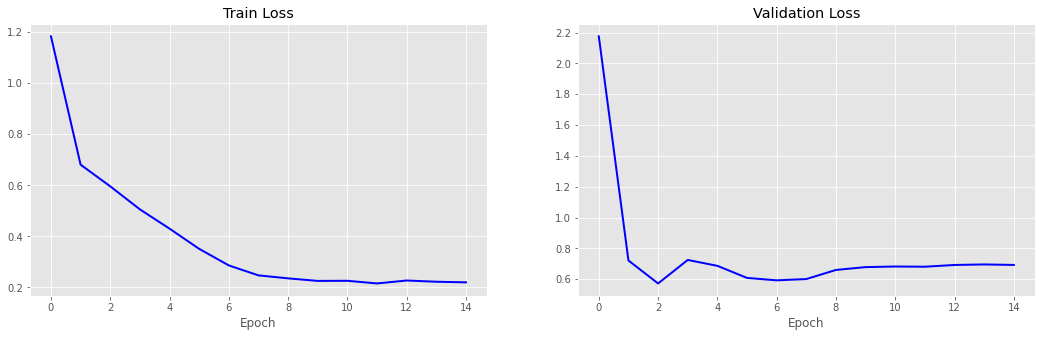

In [ ]:
## Plot
plt.style.use("ggplot")
plt.figure(figsize = (18, 5))

plt.subplot(121)
plt.plot(train_loss_cnn, color = "blue", linewidth = 2)
plt.title("Train Loss")
plt.xlabel("Epoch")

plt.subplot(122)
plt.plot(val_loss_cnn, color = "blue", linewidth = 2)
plt.title("Validation Loss")
plt.xlabel("Epoch")

plt.show()

In [ ]:
## Combine the F1 score values in a more informative way

## Training F1 Score
c1  = train_f1_cnn[0].tolist()
c2  = train_f1_cnn[1].tolist()
c3  = train_f1_cnn[2].tolist()
c4  = train_f1_cnn[3].tolist()
c5  = train_f1_cnn[4].tolist()
c6  = train_f1_cnn[5].tolist()
c7  = train_f1_cnn[6].tolist()
c8  = train_f1_cnn[7].tolist()
c9  = train_f1_cnn[8].tolist()
c10 = train_f1_cnn[9].tolist()
c11 = train_f1_cnn[10].tolist()
c12 = train_f1_cnn[11].tolist()
c13 = train_f1_cnn[12].tolist()
c14 = train_f1_cnn[13].tolist()
c15 = train_f1_cnn[14].tolist()

## Validation F1 Score
v1  = val_f1_cnn[0].tolist()
v2  = val_f1_cnn[1].tolist()
v3  = val_f1_cnn[2].tolist()
v4  = val_f1_cnn[3].tolist()
v5  = val_f1_cnn[4].tolist()
v6  = val_f1_cnn[5].tolist()
v7  = val_f1_cnn[6].tolist()
v8  = val_f1_cnn[7].tolist()
v9  = val_f1_cnn[8].tolist()
v10 = val_f1_cnn[9].tolist()
v11 = val_f1_cnn[10].tolist()
v12 = val_f1_cnn[11].tolist()
v13 = val_f1_cnn[12].tolist()
v14 = val_f1_cnn[13].tolist()
v15 = val_f1_cnn[14].tolist()

In [ ]:
## Organize F1 Score
train_f1_cnn_combined = pd.DataFrame([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15])
val_f1_cnn_combined   = pd.DataFrame([v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11, v12, v13, v14, v15])

Di seguito osserviamo le performance per le metriche di riferimento.

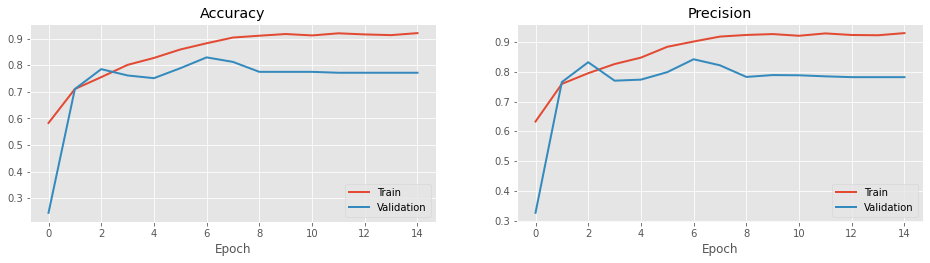

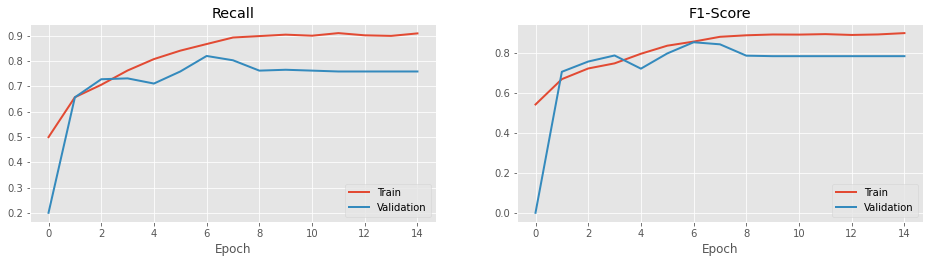

In [ ]:
plt.figure(figsize = (16, 8))

## Performance metrics
## Accuracy Plot
plt.subplot(221)
plt.plot(train_accuracy_cnn, label = "Train", linewidth = 2)
plt.plot(val_accuracy_cnn, label =  "Validation", linewidth = 2)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")

## Precision Plot
plt.subplot(222)
plt.plot(train_precision_cnn, label = "Train", linewidth = 2)
plt.plot(val_precision_cnn, label = "Validation", linewidth = 2)
plt.title("Precision")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")

plt.show()

plt.figure(figsize = (16, 8))
## Recall Plot
plt.subplot(223)
plt.plot(train_recall_cnn, label = "Train", linewidth = 2)
plt.plot(val_recall_cnn, label = "Validation", linewidth = 2)
plt.title("Recall")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")

## F1-Score Plot
plt.subplot(224)
plt.plot(train_f1_cnn_combined[0].tolist(), label = "Train", linewidth = 2)
plt.plot(val_f1_cnn_combined[0].tolist(), label = "Validation", linewidth = 2)
plt.title("F1-Score")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")

plt.show()

Utilizziamo il miglior modello salvato in precedenza, per generare previsioni sul test set.

* 0 - Glioma Tumor
* 1 - No Tumor
* 2 - Meningioma Tumor
* 3 - Pituitary Tumor

In [ ]:
## Load model
model_cnn1 = load_model("cnn_1.h5")
## Summarize model
model_cnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 16)       64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 75, 75, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0

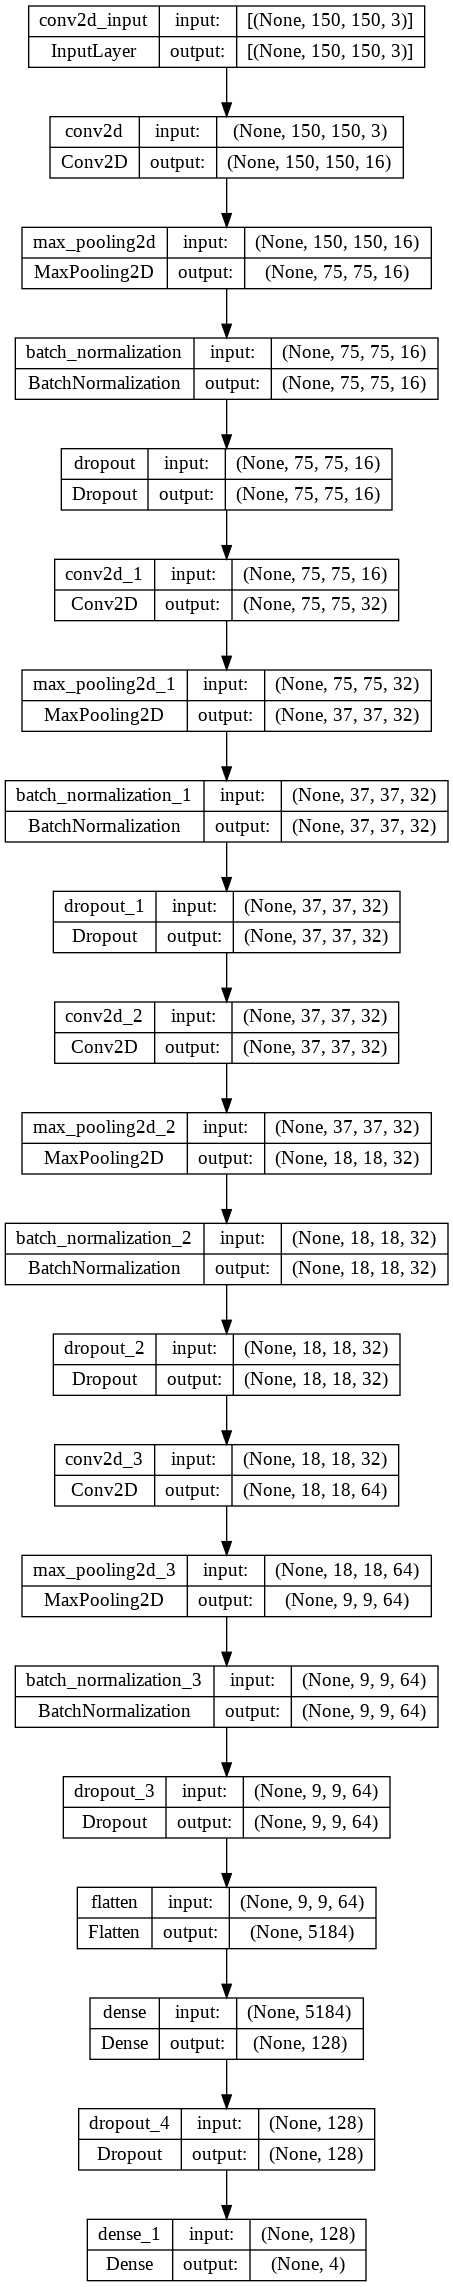

In [ ]:
## Visualize the architecture
plot_model(model_cnn, to_file = "Model_CNN_Plot.png", show_shapes = True, show_layer_names = True)

In [ ]:
## Predict with CNN
start = timeit.default_timer()

pred_cnn   = model_cnn1.predict(X_test)
y_pred_cnn = np.argmax(pred_cnn, axis = 1)

stop = timeit.default_timer()
print("Computational Time for predictions with CNN:", stop - start)

11/11 [==============================] - 0s 17ms/step
Computational Time for predictions with CNN: 0.3787077169999975


In [ ]:
## Confusion Matrix
print(classification_report(y_test_new, y_pred_cnn))

              precision    recall  f1-score   support

           0       0.83      0.71      0.76       102
           1       0.84      0.70      0.77        54
           2       0.70      0.72      0.71        94
           3       0.78      0.99      0.87        77

    accuracy                           0.78       327
   macro avg       0.79      0.78      0.78       327
weighted avg       0.78      0.78      0.77       327



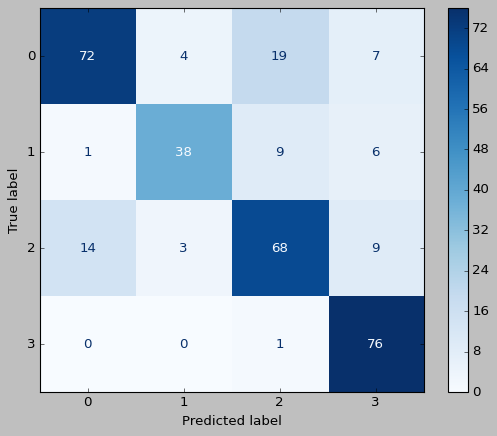

In [ ]:
plt.style.use("classic")

## Confusion Matrix Plot for CNN Version 1
cm_cnn      = confusion_matrix(y_test_new, y_pred_cnn)
cm_cnn_plot = ConfusionMatrixDisplay(cm_cnn)
cm_cnn_plot.plot(values_format = "g", cmap = "Blues")

A questo punto, per migliorare le performance è stata implementata una seconda Convolutional Neural Networks composta da più layers e più densa.

#### Convolutional Neural Network (Version 2)

In [ ]:
## Define a second CNN
model_cnn2 = tf.keras.Sequential([
    ## First Layer
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (5, 5), activation = "relu"), ## Convolution 2D
    tf.keras.layers.MaxPool2D(pool_size = (2,2)), ## Max pooling
    tf.keras.layers.BatchNormalization(),         ## Batch Normalization
    tf.keras.layers.Dropout(0.25),                ## Droput

    ## Second layer
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu"),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    ## Third layer
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu"), 
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25), 

    ## Fourth layer
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu"), 
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25), 

    ## Fifth layer
    tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), activation = "relu"), 
    tf.keras.layers.MaxPool2D(pool_size = (2,2)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25), 

    ## Output layer
    tf.keras.layers.Flatten(),                            ## adding flatten
    tf.keras.layers.Dense(1024),                          ## fully connected layers
    tf.keras.layers.Dropout(0.4),                         ## increase slightly the dropout
    tf.keras.layers.Dense(4, activation = "softmax"),     ## adding the last layer with 4 neurons, one for each classes
])

In [ ]:
## Set hyperparameters
batch_size    = 32
epochs        = 15
num_classes   = len(labels)

## Save the best model
checkpoint  = tf.keras.callbacks.ModelCheckpoint("cnn_2.h5", monitor = "val_loss", save_best_only = True, mode = "auto", verbose = 1)
reduce_lr   = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.3, patience = 2, min_delta = 0.001,
                                                   mode = "auto", verbose = 1)

## Define metrics
recall    = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
f1_score  = tfa.metrics.F1Score(num_classes = num_classes,
                                threshold = 0.5)

metrics   = ["accuracy", precision, recall, f1_score]

In [ ]:
## Compile the model
model_cnn2.compile(loss = "categorical_crossentropy",
                   optimizer = "adam",
                   metrics = metrics)

In [ ]:
## Training CNN
start = timeit.default_timer()

## Fit
history_cnn2 = model_cnn2.fit(tf.cast(X_train, tf.float32), y_train, validation_split = 0.1,
                              epochs = epochs, verbose = 1,
                              batch_size = batch_size,  callbacks = [checkpoint, reduce_lr])

stop = timeit.default_timer()
print("Computational Time CNN Version 2:", stop - start)

Epoch 1/15
83/83 [==============================] - ETA: 0s - loss: 2.7732 - accuracy: 0.5376 - precision_1: 0.5455 - recall_1: 0.5267 - f1_score: 0.5223
Epoch 1: val_loss improved from inf to 33.00837, saving model to cnn_2.h5
83/83 [==============================] - 10s 92ms/step - loss: 2.7732 - accuracy: 0.5376 - precision_1: 0.5455 - recall_1: 0.5267 - f1_score: 0.5223 - val_loss: 33.0084 - val_accuracy: 0.1701 - val_precision_1: 0.1701 - val_recall_1: 0.1701 - val_f1_score: 0.0958 - lr: 0.0010
Epoch 2/15
82/83 [============================>.] - ETA: 0s - loss: 1.6429 - accuracy: 0.6307 - precision_1: 0.6397 - recall_1: 0.6212 - f1_score: 0.6248
Epoch 2: val_loss improved from 33.00837 to 4.48238, saving model to cnn_2.h5
83/83 [==============================] - 6s 69ms/step - loss: 1.6361 - accuracy: 0.6319 - precision_1: 0.6408 - recall_1: 0.6224 - f1_score: 0.6259 - val_loss: 4.4824 - val_accuracy: 0.4184 - val_precision_1: 0.4261 - val_recall_1: 0.4116 - val_f1_score: 0.4264 -

In [ ]:
## Performance CNN 2

## Training
train_loss_cnn2      = history_cnn2.history["loss"]
train_accuracy_cnn2  = history_cnn2.history["accuracy"]
train_precision_cnn2 = history_cnn2.history["precision_1"]
train_recall_cnn2    = history_cnn2.history["recall_1"]
train_f1_cnn2        = history_cnn2.history["f1_score"]

## Validation
val_loss_cnn2      = history_cnn2.history["val_loss"]
val_accuracy_cnn2  = history_cnn2.history["val_accuracy"]
val_precision_cnn2 = history_cnn2.history["val_precision_1"]
val_recall_cnn2    = history_cnn2.history["val_recall_1"]
val_f1_cnn2        = history_cnn2.history["val_f1_score"]

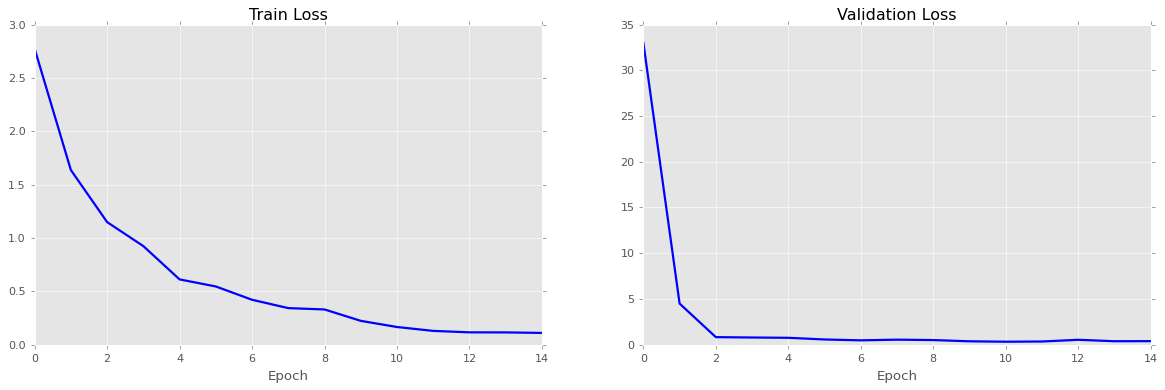

In [ ]:
## Plot
plt.style.use("ggplot")
plt.figure(figsize = (18, 5))

plt.subplot(121)
plt.plot(train_loss_cnn2, color = "blue", linewidth = 2)
plt.title("Train Loss")
plt.xlabel("Epoch")

plt.subplot(122)
plt.plot(val_loss_cnn2, color = "blue", linewidth = 2)
plt.title("Validation Loss")
plt.xlabel("Epoch")

plt.show()

In [ ]:
## Combine the F1 score values in a more informative way

## Training F1 Score
c1  = train_f1_cnn2[0].tolist()
c2  = train_f1_cnn2[1].tolist()
c3  = train_f1_cnn2[2].tolist()
c4  = train_f1_cnn2[3].tolist()
c5  = train_f1_cnn2[4].tolist()
c6  = train_f1_cnn2[5].tolist()
c7  = train_f1_cnn2[6].tolist()
c8  = train_f1_cnn2[7].tolist()
c9  = train_f1_cnn2[8].tolist()
c10 = train_f1_cnn2[9].tolist()
c11 = train_f1_cnn2[10].tolist()
c12 = train_f1_cnn2[11].tolist()
c13 = train_f1_cnn2[12].tolist()
c14 = train_f1_cnn2[13].tolist()
c15 = train_f1_cnn2[14].tolist()

## Validation F1 Score
v1  = val_f1_cnn2[0].tolist()
v2  = val_f1_cnn2[1].tolist()
v3  = val_f1_cnn2[2].tolist()
v4  = val_f1_cnn2[3].tolist()
v5  = val_f1_cnn2[4].tolist()
v6  = val_f1_cnn2[5].tolist()
v7  = val_f1_cnn2[6].tolist()
v8  = val_f1_cnn2[7].tolist()
v9  = val_f1_cnn2[8].tolist()
v10 = val_f1_cnn2[9].tolist()
v11 = val_f1_cnn2[10].tolist()
v12 = val_f1_cnn2[11].tolist()
v13 = val_f1_cnn2[12].tolist()
v14 = val_f1_cnn2[13].tolist()
v15 = val_f1_cnn2[14].tolist()

In [ ]:
## Organize F1 Score
train_f1_cnn2_combined = pd.DataFrame([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15])
val_f1_cnn2_combined   = pd.DataFrame([v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11, v12, v13, v14, v15])

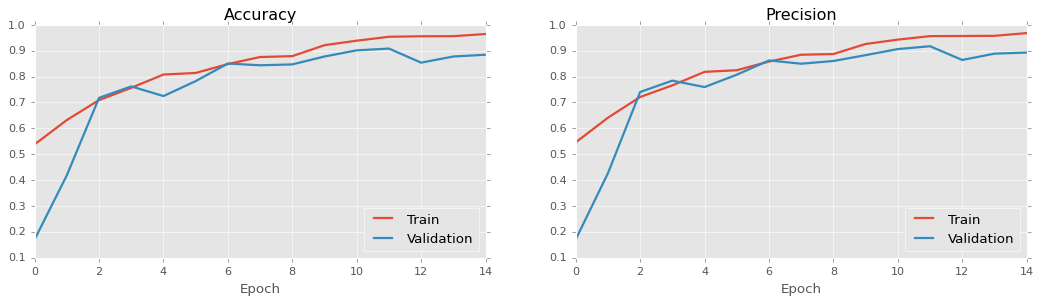

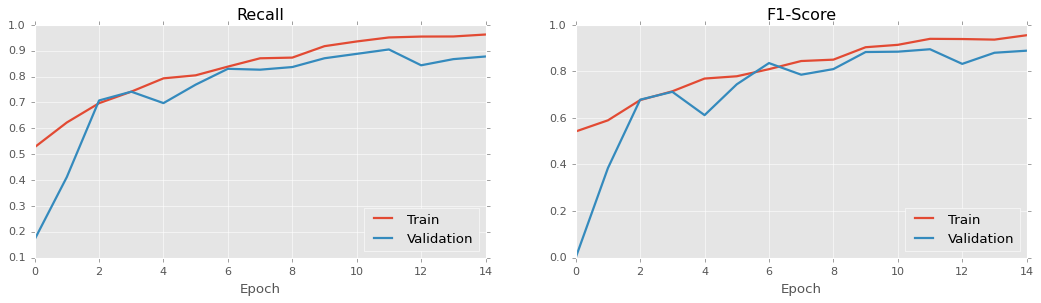

In [ ]:
plt.figure(figsize = (16, 8))

## Performance metrics
## Accuracy Plot
plt.subplot(221)
plt.plot(train_accuracy_cnn2, label = "Train", linewidth = 2)
plt.plot(val_accuracy_cnn2, label =  "Validation", linewidth = 2)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")

## Precision Plot
plt.subplot(222)
plt.plot(train_precision_cnn2, label = "Train", linewidth = 2)
plt.plot(val_precision_cnn2, label = "Validation", linewidth = 2)
plt.title("Precision")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")

plt.show()

plt.figure(figsize = (16, 8))
## Recall Plot
plt.subplot(223)
plt.plot(train_recall_cnn2, label = "Train", linewidth = 2)
plt.plot(val_recall_cnn2, label = "Validation", linewidth = 2)
plt.title("Recall")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")

## F1-Score Plot
plt.subplot(224)
plt.plot(train_f1_cnn2_combined[0].tolist(), label = "Train", linewidth = 2)
plt.plot(val_f1_cnn2_combined[0].tolist(), label = "Validation", linewidth = 2)
plt.title("F1-Score")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")

plt.show()

A questo punto, viene utilizzato il miglior modello per generare previsioni sul test set.

* 0 - Glioma Tumor
* 1 - No Tumor
* 2 - Meningioma Tumor
* 3 - Pituitary Tumor

In [ ]:
## Load model
model_cnn2 = load_model("cnn_2.h5")
## Summarize model
model_cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 146, 146, 64)      4864      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 73, 73, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 73, 73, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 35, 35, 128)     

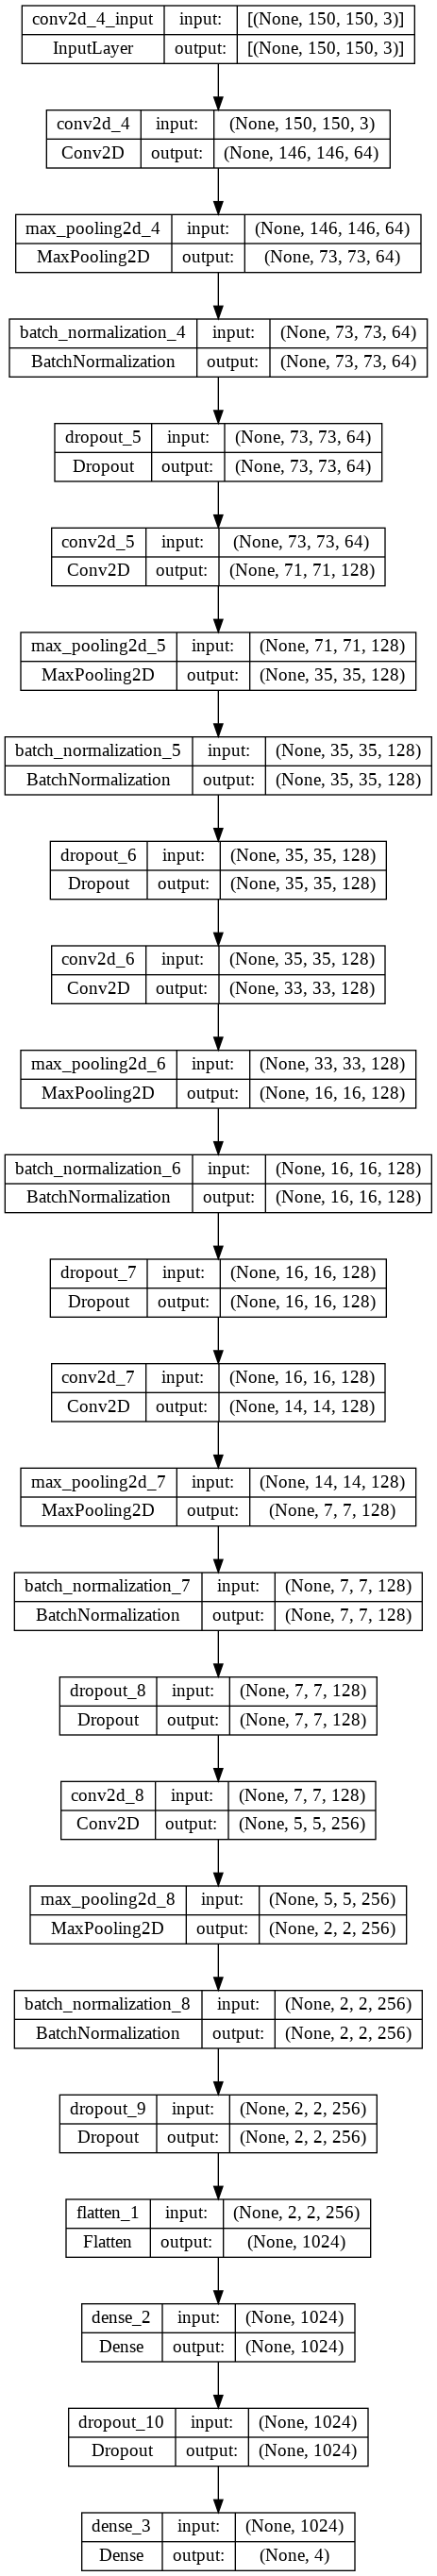

In [ ]:
## Visualize the architecture
plot_model(model_cnn2, to_file = "Model_CNN2_Plot.png", show_shapes = True, show_layer_names = True)

In [ ]:
## Predict with CNN 2
start = timeit.default_timer()

pred_cnn2   = model_cnn2.predict(X_test)
y_pred_cnn2 = np.argmax(pred_cnn2, axis = 1)

stop = timeit.default_timer()
print("Computational Time for predictions with CNN 2:", stop - start)

11/11 [==============================] - 1s 42ms/step
Computational Time for predictions with CNN 2: 0.7944730559993332


In [ ]:
## Confusion Matrix
print(classification_report(y_test_new, y_pred_cnn2))

              precision    recall  f1-score   support

           0       0.93      0.84      0.89       102
           1       0.87      0.96      0.91        54
           2       0.91      0.86      0.89        94
           3       0.90      1.00      0.94        77

    accuracy                           0.91       327
   macro avg       0.90      0.92      0.91       327
weighted avg       0.91      0.91      0.90       327



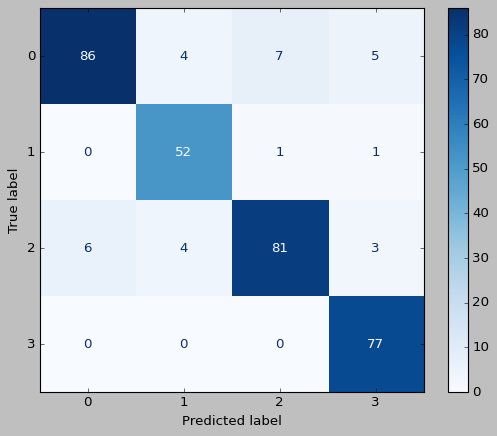

In [ ]:
plt.style.use("classic")

## Confusion Matrix Plot
cm_cnn2       = confusion_matrix(y_test_new, y_pred_cnn2)
cm_cnn2_plot2 = ConfusionMatrixDisplay(cm_cnn2)
cm_cnn2_plot2.plot(values_format = "g", cmap = "Blues")

Come si può osservare, le performance sono decisamente migliori rispetto al modello precedente.

Nonostante le performance ottenute con la seconda CNN siano ottime, si vuole testare la capacità previsiva di modelli pre-trained utilizzando la tecnica del **transfer learning**.

Questo approccio si basa sul riutilizzo di reti neurali note in letteratura che sono state addestrate su dataset contenenti numerose immagini e con un diverso numero di classi. Nel transfer learning, un modello sfrutta la conoscenza acquisita da un'attività precedente per migliorare la generalizzazione su un'altra.

In questo caso i modelli scelti sono: **VGG16**, **ResNet50** ed **EfficientNetB0**, ognuno addestrato sul dataset [ImageNet.](https://en.wikipedia.org/wiki/ImageNet)

I vantaggi dell'utilizzo di questa tecnica sono:

- Per raggiungere le stesse performance con una rete non pre-addestrata, ci vorrebbero più dati ed un tempo maggiore.

- Non c'è bisogno di implementare un'architettura nuova, ma si può utilizzare una già esistente, a patto che il modello pre-trained sia stato utilizzato per lo stesso task che stiamo affrontando.

- Garantisce delle ottime performance anche quando non si hanno abbastanza dati.


#### VGG 16

VGG-16 è un’architettura di rete neurale progettata da [Visual Geometry Group](https://www.robots.ox.ac.uk/~vgg/), il dipartimento di scienze ingegneristiche dell’Università di Oxford, con 13 convolutional layers e 3 fully connected layers per task di classificazione ed identificazione.

Sempre presente poi la ReLU ereditata da AlexNet.

In [ ]:
## Transfer Learning
vgg_model = VGG16(include_top = False,
                  weights = "imagenet", 
                  input_shape = (image_size, image_size, 3))

In [ ]:
## Change the last layer of the pre-trained mdoel
pre_model_vgg = vgg_model.output
pre_model_vgg = tf.keras.layers.GlobalAveragePooling2D()(pre_model_vgg)
pre_model_vgg = tf.keras.layers.Dense(128, activation = "relu")(pre_model_vgg)
pre_model_vgg = tf.keras.layers.Dropout(rate = 0.25)(pre_model_vgg)
pre_model_vgg = tf.keras.layers.Dense(len(labels), activation = "softmax")(pre_model_vgg)
pre_model_vgg = tf.keras.models.Model(inputs = vgg_model.input, outputs = pre_model_vgg)

In [ ]:
## Set hyperparameters
batch_size    = 32
epochs        = 15
num_classes   = len(labels)

## Save the best model
checkpoint  = tf.keras.callbacks.ModelCheckpoint("vggnet.h5", monitor = "val_loss", save_best_only = True, mode = "auto", verbose = 1)
reduce_lr   = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.3, patience = 2, min_delta = 0.001,
                                                   mode = "auto", verbose = 1)

## Define metrics
recall    = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
f1_score  = tfa.metrics.F1Score(num_classes = num_classes,
                                threshold = 0.5)

metrics   = ["accuracy", precision, recall, f1_score]

In [ ]:
## Compile the model
pre_model_vgg.compile(loss = "categorical_crossentropy",
                      optimizer = "Adam",
                      metrics = metrics)

In [ ]:
## Train the model
start = timeit.default_timer()

history_pre_mod_vgg = pre_model_vgg.fit(X_train, y_train, validation_split = 0.1,
                                        epochs = epochs, verbose = 1, batch_size = batch_size,
                                        callbacks = [checkpoint, reduce_lr])

stop = timeit.default_timer()
print("Computational Time for VGG 16:", stop - start)

Epoch 1/15
83/83 [==============================] - ETA: 0s - loss: 2.3468 - accuracy: 0.2891 - precision_2: 0.2474 - recall_2: 0.0269 - f1_score: 0.0501
Epoch 1: val_loss improved from inf to 1.37284, saving model to vggnet.h5
83/83 [==============================] - 28s 274ms/step - loss: 2.3468 - accuracy: 0.2891 - precision_2: 0.2474 - recall_2: 0.0269 - f1_score: 0.0501 - val_loss: 1.3728 - val_accuracy: 0.2551 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/15
83/83 [==============================] - ETA: 0s - loss: 1.3656 - accuracy: 0.2860 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.0000e+00
Epoch 2: val_loss improved from 1.37284 to 1.36474, saving model to vggnet.h5
83/83 [==============================] - 19s 225ms/step - loss: 1.3656 - accuracy: 0.2860 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 1.3647 - val_accuracy: 0.2789 - val_precision_2: 0.0000e+00 - val

In [ ]:
## Performance VGG 16

## Training
train_loss_vgg      = history_pre_mod_vgg.history["loss"]
train_accuracy_vgg  = history_pre_mod_vgg.history["accuracy"]
train_precision_vgg = history_pre_mod_vgg.history["precision_2"]
train_recall_vgg    = history_pre_mod_vgg.history["recall_2"]
train_f1_vgg        = history_pre_mod_vgg.history["f1_score"]

## Validation
val_loss_vgg      = history_pre_mod_vgg.history["val_loss"]
val_accuracy_vgg  = history_pre_mod_vgg.history["val_accuracy"]
val_precision_vgg = history_pre_mod_vgg.history["val_precision_2"]
val_recall_vgg    = history_pre_mod_vgg.history["val_recall_2"]
val_f1_vgg        = history_pre_mod_vgg.history["val_f1_score"]

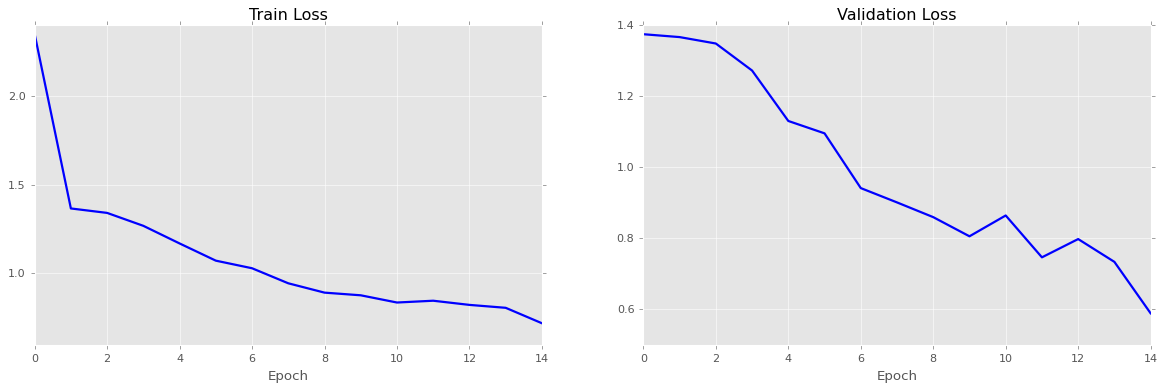

In [ ]:
plt.style.use("ggplot")

## Plot
plt.figure(figsize = (18, 5))

plt.subplot(121)
plt.plot(train_loss_vgg, color = "blue", linewidth = 2)
plt.title("Train Loss")
plt.xlabel("Epoch")

plt.subplot(122)
plt.plot(val_loss_vgg, color = "blue", linewidth = 2)
plt.title("Validation Loss")
plt.xlabel("Epoch")

plt.show()

In [ ]:
## Combine the F1 score values in a more informative way

## Training F1 Score
c1  = train_f1_vgg[0].tolist()
c2  = train_f1_vgg[1].tolist()
c3  = train_f1_vgg[2].tolist()
c4  = train_f1_vgg[3].tolist()
c5  = train_f1_vgg[4].tolist()
c6  = train_f1_vgg[5].tolist()
c7  = train_f1_vgg[6].tolist()
c8  = train_f1_vgg[7].tolist()
c9  = train_f1_vgg[8].tolist()
c10 = train_f1_vgg[9].tolist()
c11 = train_f1_vgg[10].tolist()
c12 = train_f1_vgg[11].tolist()
c13 = train_f1_vgg[12].tolist()
c14 = train_f1_vgg[13].tolist()
c15 = train_f1_vgg[14].tolist()

## Validation F1 Score
v1  = val_f1_vgg[0].tolist()
v2  = val_f1_vgg[1].tolist()
v3  = val_f1_vgg[2].tolist()
v4  = val_f1_vgg[3].tolist()
v5  = val_f1_vgg[4].tolist()
v6  = val_f1_vgg[5].tolist()
v7  = val_f1_vgg[6].tolist()
v8  = val_f1_vgg[7].tolist()
v9  = val_f1_vgg[8].tolist()
v10 = val_f1_vgg[9].tolist()
v11 = val_f1_vgg[10].tolist()
v12 = val_f1_vgg[11].tolist()
v13 = val_f1_vgg[12].tolist()
v14 = val_f1_vgg[13].tolist()
v15 = val_f1_vgg[14].tolist()

In [ ]:
## Organize F1 Score
train_f1_vgg_combined = pd.DataFrame([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15])
val_f1_vgg_combined   = pd.DataFrame([v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11, v12, v13, v14, v15])

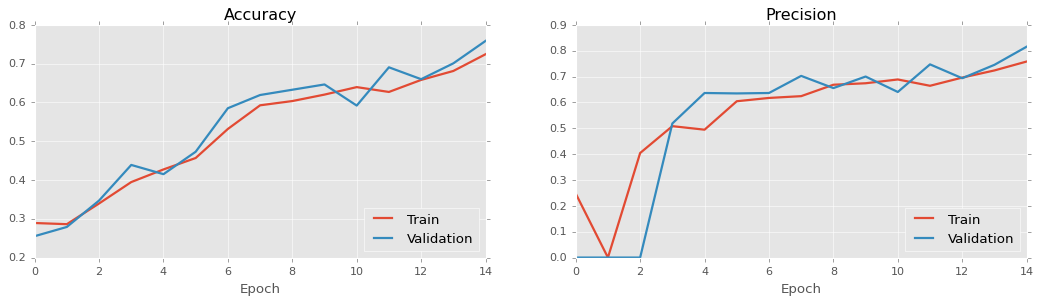

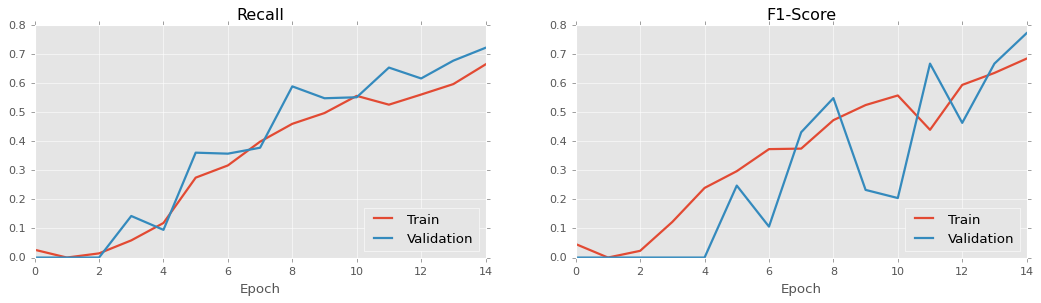

In [ ]:
plt.figure(figsize = (16, 8))

## Performance metrics
## Accuracy Plot
plt.subplot(221)
plt.plot(train_accuracy_vgg, label = "Train", linewidth = 2)
plt.plot(val_accuracy_vgg, label =  "Validation", linewidth = 2)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")

## Precision Plot
plt.subplot(222)
plt.plot(train_precision_vgg, label = "Train", linewidth = 2)
plt.plot(val_precision_vgg, label = "Validation", linewidth = 2)
plt.title("Precision")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")
plt.show()

plt.figure(figsize = (16, 8))
## Recall Plot
plt.subplot(223)
plt.plot(train_recall_vgg, label = "Train", linewidth = 2)
plt.plot(val_recall_vgg, label = "Validation", linewidth = 2)
plt.title("Recall")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")

## F1-Score Plot
plt.subplot(224)
plt.plot(train_f1_vgg_combined[0].tolist(), label = "Train", linewidth = 2)
plt.plot(val_f1_vgg_combined[0].tolist(), label = "Validation", linewidth = 2)
plt.title("F1-Score")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")

plt.show()

A questo punto, viene utilizzato il miglior modello per generare previsioni sul test set.

* 0 - Glioma Tumor
* 1 - No Tumor
* 2 - Meningioma Tumor
* 3 - Pituitary Tumor

In [ ]:
## Load model
model_vgg = load_model("vggnet.h5")
## Summarize model
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

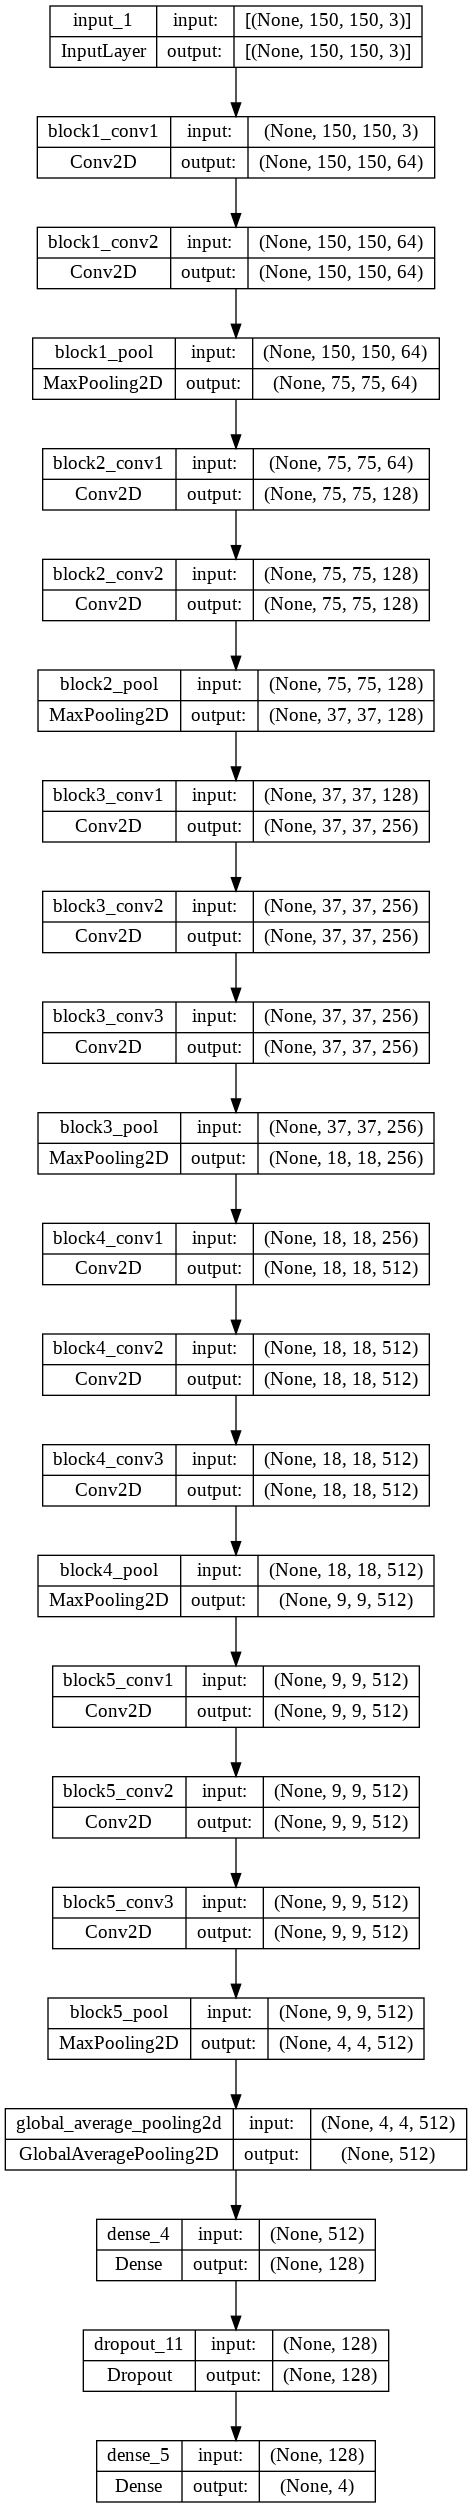

In [ ]:
## Visualize the architecture
plot_model(model_vgg, to_file = "Model_VGG_Plot.png", show_shapes = True, show_layer_names = True)

In [ ]:
## Predict
start = timeit.default_timer()

pred_vgg   = model_vgg.predict(X_test)
y_pred_vgg = np.argmax(pred_vgg, axis = 1)

stop = timeit.default_timer()
print("Computational Time for predictions with VGG 16:", stop - start)

11/11 [==============================] - 2s 156ms/step
Computational Time for predictions with VGG 16: 1.7573433830002614


In [ ]:
## Confusion Matrix
print(classification_report(y_test_new, y_pred_vgg))

              precision    recall  f1-score   support

           0       0.77      0.74      0.75       102
           1       0.62      1.00      0.77        54
           2       0.72      0.47      0.57        94
           3       0.84      0.88      0.86        77

    accuracy                           0.74       327
   macro avg       0.74      0.77      0.74       327
weighted avg       0.75      0.74      0.73       327



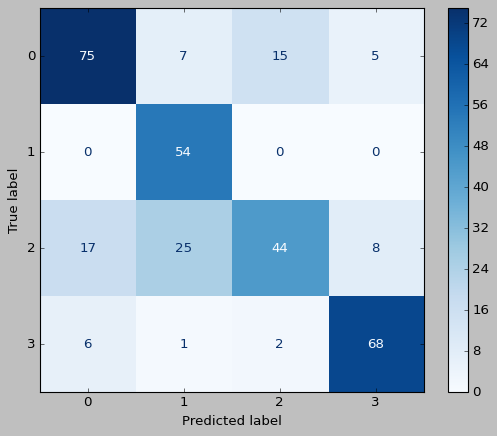

In [ ]:
plt.style.use("classic")

## Confusion Matrix Plot
cm_vgg      = confusion_matrix(y_test_new, y_pred_vgg)
cm_vgg_plot = ConfusionMatrixDisplay(cm_vgg)
cm_vgg_plot.plot(values_format = "g", cmap = "Blues")

Come possiamo osservare, le performance della VGG16 sono basse se confrontate con la seconda CNN. 

#### ResNet 50

ResNet-50 è una rete neurale convoluzionale profonda 50 livelli. ResNet, abbreviazione di Residual Networks, è una classica rete neurale utilizzata come spina dorsale per molte attività di visione artificiale. La svolta fondamentale con ResNet è stata che ha permesso di addestrare reti neurali estremamente profonde con oltre 150 livelli. È una rete neurale innovativa che è stata introdotta per la prima volta da Kaiming He, Xiangyu Zhang, Shaoqing Ren e Jian Sun nel loro documento di ricerca sulla visione artificiale del 2015 intitolato [*Deep Residual Learning for Image Recognition*](https://arxiv.org/pdf/1512.03385.pdf).

In [ ]:
## Transfer Learning
res_net50 = ResNet50(include_top = False,
                     weights = "imagenet", 
                     input_shape = (image_size, image_size, 3))

In [ ]:
## Change the last layer of the pre-trained mdoel
pre_model_resnet = res_net50.output
pre_model_resnet = tf.keras.layers.GlobalAveragePooling2D()(pre_model_resnet)
pre_model_resnet = tf.keras.layers.Dropout(rate = 0.5)(pre_model_resnet)
pre_model_resnet = tf.keras.layers.Dense(len(labels), activation = "softmax")(pre_model_resnet)
pre_model_resnet = tf.keras.models.Model(inputs = res_net50.input, outputs = pre_model_resnet)

In [ ]:
## Set hyperparameters
batch_size    = 32
epochs        = 15
num_classes   = len(labels)

## Save the best model
checkpoint  = tf.keras.callbacks.ModelCheckpoint("resnet.h5", monitor = "val_loss", save_best_only = True, mode = "auto", verbose = 1)
reduce_lr   = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.3, patience = 2, min_delta = 0.001,
                                                   mode = "auto", verbose = 1)

## Define metrics
recall    = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
f1_score  = tfa.metrics.F1Score(num_classes = num_classes,
                                threshold = 0.5)

metrics   = ["accuracy", precision, recall, f1_score]

In [ ]:
## Compile the model
pre_model_resnet.compile(loss = "categorical_crossentropy",
                         optimizer = "Adam",
                          metrics = metrics)

In [ ]:
## Train the model
start = timeit.default_timer()

history_pre_mod_resnet = pre_model_resnet.fit(X_train, y_train, validation_split = 0.1,
                                              epochs = epochs, verbose = 1, batch_size = batch_size,
                                              callbacks = [checkpoint, reduce_lr])

stop = timeit.default_timer()
print("Computational Time for ResNet50:", stop - start)

Epoch 1/15
83/83 [==============================] - ETA: 0s - loss: 0.8922 - accuracy: 0.7034 - precision_3: 0.7601 - recall_3: 0.6508 - f1_score: 0.6908
Epoch 1: val_loss improved from inf to 154.68240, saving model to resnet.h5
83/83 [==============================] - 26s 229ms/step - loss: 0.8922 - accuracy: 0.7034 - precision_3: 0.7601 - recall_3: 0.6508 - f1_score: 0.6908 - val_loss: 154.6824 - val_accuracy: 0.2789 - val_precision_3: 0.2789 - val_recall_3: 0.2789 - val_f1_score: 0.1183 - lr: 0.0010
Epoch 2/15
83/83 [==============================] - ETA: 0s - loss: 0.3897 - accuracy: 0.8725 - precision_3: 0.8930 - recall_3: 0.8434 - f1_score: 0.8659
Epoch 2: val_loss improved from 154.68240 to 2.58527, saving model to resnet.h5
83/83 [==============================] - 16s 199ms/step - loss: 0.3897 - accuracy: 0.8725 - precision_3: 0.8930 - recall_3: 0.8434 - f1_score: 0.8659 - val_loss: 2.5853 - val_accuracy: 0.3571 - val_precision_3: 0.3643 - val_recall_3: 0.3469 - val_f1_score: 

In [ ]:
## Performance ResNet 50

## Training
train_loss_resnet      = history_pre_mod_resnet.history["loss"]
train_accuracy_resnet  = history_pre_mod_resnet.history["accuracy"]
train_precision_resnet = history_pre_mod_resnet.history["precision_3"]
train_recall_resnet    = history_pre_mod_resnet.history["recall_3"]
train_f1_resnet        = history_pre_mod_resnet.history["f1_score"]

## Validation
val_loss_resnet      = history_pre_mod_resnet.history["val_loss"]
val_accuracy_resnet  = history_pre_mod_resnet.history["val_accuracy"]
val_precision_resnet = history_pre_mod_resnet.history["val_precision_3"]
val_recall_resnet    = history_pre_mod_resnet.history["val_recall_3"]
val_f1_resnet        = history_pre_mod_resnet.history["val_f1_score"]

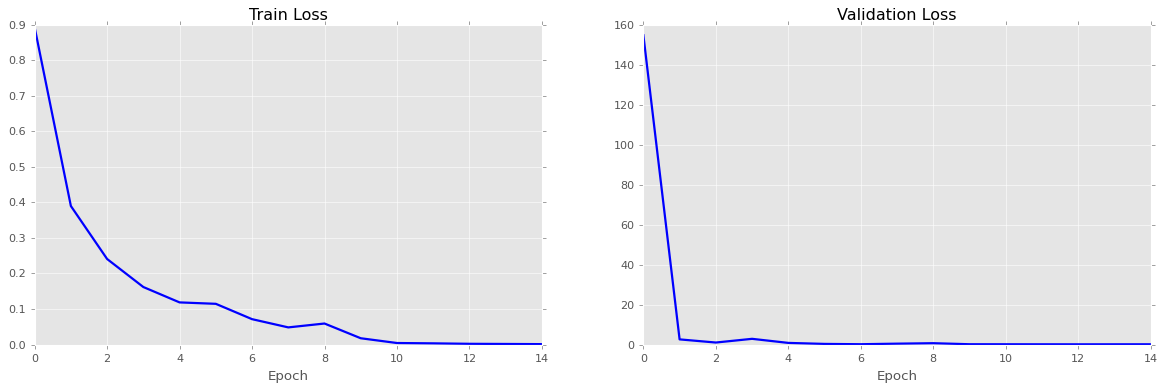

In [ ]:
plt.style.use("ggplot")

## Plot
plt.figure(figsize = (18, 5))

plt.subplot(121)
plt.plot(train_loss_resnet, color = "blue", linewidth = 2)
plt.title("Train Loss")
plt.xlabel("Epoch")

plt.subplot(122)
plt.plot(val_loss_resnet, color = "blue", linewidth = 2)
plt.title("Validation Loss")
plt.xlabel("Epoch")

plt.show()

In [ ]:
## Combine the F1 score

## Training F1 Score
c1  = train_f1_resnet[0].tolist()
c2  = train_f1_resnet[1].tolist()
c3  = train_f1_resnet[2].tolist()
c4  = train_f1_resnet[3].tolist()
c5  = train_f1_resnet[4].tolist()
c6  = train_f1_resnet[5].tolist()
c7  = train_f1_resnet[6].tolist()
c8  = train_f1_resnet[7].tolist()
c9  = train_f1_resnet[8].tolist()
c10 = train_f1_resnet[9].tolist()
c11 = train_f1_resnet[10].tolist()
c12 = train_f1_resnet[11].tolist()
c13 = train_f1_resnet[12].tolist()
c14 = train_f1_resnet[13].tolist()
c15 = train_f1_resnet[14].tolist()

## Validation F1 Score
v1  = val_f1_resnet[0].tolist()
v2  = val_f1_resnet[1].tolist()
v3  = val_f1_resnet[2].tolist()
v4  = val_f1_resnet[3].tolist()
v5  = val_f1_resnet[4].tolist()
v6  = val_f1_resnet[5].tolist()
v7  = val_f1_resnet[6].tolist()
v8  = val_f1_resnet[7].tolist()
v9  = val_f1_resnet[8].tolist()
v10 = val_f1_resnet[9].tolist()
v11 = val_f1_resnet[10].tolist()
v12 = val_f1_resnet[11].tolist()
v13 = val_f1_resnet[12].tolist()
v14 = val_f1_resnet[13].tolist()
v15 = val_f1_resnet[14].tolist()

In [ ]:
## Organize F1 Score
train_f1_resnet_combined = pd.DataFrame([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15])
val_f1_resnet_combined   = pd.DataFrame([v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11, v12, v13, v14, v15])

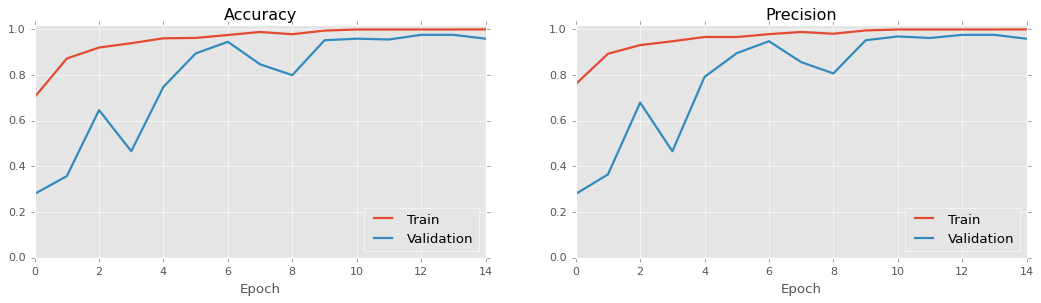

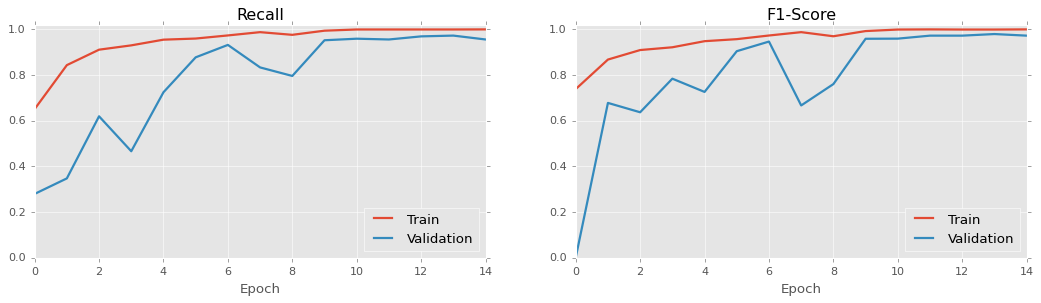

In [ ]:
plt.figure(figsize = (16, 8))

## Performance metrics
## Accuracy Plot
plt.subplot(221)
plt.plot(train_accuracy_resnet, label = "Train", linewidth = 2)
plt.plot(val_accuracy_resnet, label =  "Validation", linewidth = 2)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylim(0, 1.02)
plt.legend(loc = "lower right")

## Precision Plot
plt.subplot(222)
plt.plot(train_precision_resnet, label = "Train", linewidth = 2)
plt.plot(val_precision_resnet, label = "Validation", linewidth = 2)
plt.title("Precision")
plt.xlabel("Epoch")
plt.ylim(0, 1.02)
plt.legend(loc = "lower right")
plt.show()

plt.figure(figsize = (16, 8))
## Recall Plot
plt.subplot(223)
plt.plot(train_recall_resnet, label = "Train", linewidth = 2)
plt.plot(val_recall_resnet, label = "Validation", linewidth = 2)
plt.title("Recall")
plt.xlabel("Epoch")
plt.ylim(0, 1.02)
plt.legend(loc = "lower right")

## F1-Score Plot
plt.subplot(224)
plt.plot(train_f1_resnet_combined[0].tolist(), label = "Train", linewidth = 2)
plt.plot(val_f1_resnet_combined[0].tolist(), label = "Validation", linewidth = 2)
plt.title("F1-Score")
plt.xlabel("Epoch")
plt.ylim(0, 1.02)
plt.legend(loc = "lower right")

plt.show()

A questo punto, viene utilizzato il miglior modello per generare previsioni sul test set.

* 0 - Glioma Tumor
* 1 - No Tumor
* 2 - Meningioma Tumor
* 3 - Pituitary Tumor

In [ ]:
## Load model
model_resnet = load_model("resnet.h5")
## Summarize model
model_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

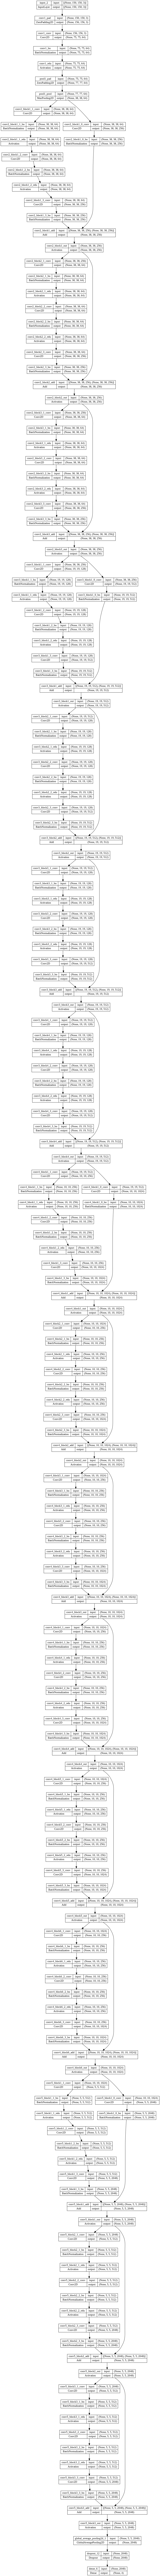

In [ ]:
## Visualize the architecture
plot_model(model_resnet, to_file = "Model_RESNET_Plot.png", show_shapes = True, show_layer_names = True)

In [ ]:
## Predict
start = timeit.default_timer()

pred_resnet   = model_resnet.predict(X_test)
y_pred_resnet = np.argmax(pred_resnet, axis = 1)

stop = timeit.default_timer()
print("Computational Time for predictions with ResNet50:", stop - start)

11/11 [==============================] - 2s 95ms/step
Computational Time for predictions with ResNet50: 1.892345552999359


In [ ]:
## Confusion Matrix
print(classification_report(y_test_new, y_pred_resnet))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       102
           1       0.91      0.96      0.94        54
           2       0.93      0.98      0.95        94
           3       0.99      0.99      0.99        77

    accuracy                           0.95       327
   macro avg       0.95      0.96      0.95       327
weighted avg       0.96      0.95      0.95       327



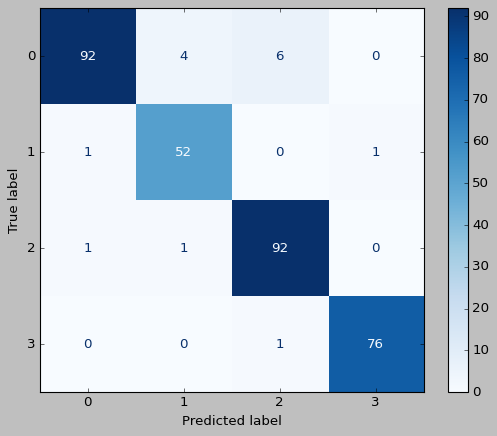

In [ ]:
plt.style.use("classic")

## Confusion Matrix Plot
cm_resnet      = confusion_matrix(y_test_new, y_pred_resnet)
cm_resnet_plot = ConfusionMatrixDisplay(cm_resnet)
cm_resnet_plot.plot(values_format = "g", cmap = "Blues")

#### Efficient Net B0

EfficientNet è un'architettura di rete neurale convoluzionale e un metodo di ridimensionamento che ridimensiona uniformemente tutte le dimensioni di profondità/larghezza/risoluzione utilizzando un coefficiente composto. A differenza della pratica convenzionale che ridimensiona arbitrariamente questi fattori, il metodo di ridimensionamento EfficientNet ridimensiona in modo uniforme la larghezza, la profondità e la risoluzione della rete con un set di coefficienti di ridimensionamento fissi.

In [ ]:
## Transfer Learning
eff_net = EfficientNetB0(weights = "imagenet",
                         include_top = False,
                         input_shape = (image_size, image_size, 3))

In [ ]:
## Change the last layer of the pre-trained mdoel
pre_model_B0 = eff_net.output
pre_model_B0 = tf.keras.layers.GlobalAveragePooling2D()(pre_model_B0)
pre_model_B0 = tf.keras.layers.Dropout(rate = 0.5)(pre_model_B0)
pre_model_B0 = tf.keras.layers.Dense(len(labels), activation = "softmax")(pre_model_B0)
pre_model_B0 = tf.keras.models.Model(inputs = eff_net.input, outputs = pre_model_B0)

In [ ]:
## Set hyperparameters
batch_size    = 32
epochs        = 15
num_classes   = len(labels)

## Save the best model
checkpoint  = tf.keras.callbacks.ModelCheckpoint("effnet.h5", monitor = "val_loss", save_best_only = True, mode = "auto", verbose = 1)
reduce_lr   = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.3, patience = 2, min_delta = 0.001,
                                                   mode = "auto", verbose = 1)

## Define metrics
recall    = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
f1_score  = tfa.metrics.F1Score(num_classes = num_classes,
                                threshold = 0.5)

metrics   = ["accuracy", precision, recall, f1_score]

In [ ]:
## Compile the model
pre_model_B0.compile(loss = "categorical_crossentropy",
                     optimizer = "Adam",
                     metrics = metrics)

In [ ]:
## Train the model
start = timeit.default_timer()

history_pre_mod_B0 = pre_model_B0.fit(X_train, y_train, validation_split = 0.1,
                                      epochs = epochs, verbose = 1, batch_size = batch_size,
                                      callbacks = [checkpoint, reduce_lr])

stop = timeit.default_timer()
print("Computational Time for Efficient Net B0:", stop - start)

Epoch 1/15
83/83 [==============================] - ETA: 0s - loss: 0.4954 - accuracy: 0.8135 - precision_4: 0.8596 - recall_4: 0.7715 - f1_score: 0.8128
Epoch 1: val_loss improved from inf to 0.28003, saving model to effnet.h5
83/83 [==============================] - 29s 230ms/step - loss: 0.4954 - accuracy: 0.8135 - precision_4: 0.8596 - recall_4: 0.7715 - f1_score: 0.8128 - val_loss: 0.2800 - val_accuracy: 0.9082 - val_precision_4: 0.9164 - val_recall_4: 0.8946 - val_f1_score: 0.9072 - lr: 0.0010
Epoch 2/15
83/83 [==============================] - ETA: 0s - loss: 0.2071 - accuracy: 0.9285 - precision_4: 0.9381 - recall_4: 0.9168 - f1_score: 0.9293
Epoch 2: val_loss improved from 0.28003 to 0.25733, saving model to effnet.h5
83/83 [==============================] - 14s 166ms/step - loss: 0.2071 - accuracy: 0.9285 - precision_4: 0.9381 - recall_4: 0.9168 - f1_score: 0.9293 - val_loss: 0.2573 - val_accuracy: 0.9320 - val_precision_4: 0.9384 - val_recall_4: 0.9320 - val_f1_score: 0.9319

In [ ]:
## Performance EfficientNet B0

## Training
train_loss_eff      = history_pre_mod_B0.history["loss"]
train_accuracy_eff  = history_pre_mod_B0.history["accuracy"]
train_precision_eff = history_pre_mod_B0.history["precision_4"]
train_recall_eff    = history_pre_mod_B0.history["recall_4"]
train_f1_eff        = history_pre_mod_B0.history["f1_score"]

## Validation
val_loss_eff      = history_pre_mod_B0.history["val_loss"]
val_accuracy_eff  = history_pre_mod_B0.history["val_accuracy"]
val_precision_eff = history_pre_mod_B0.history["val_precision_4"]
val_recall_eff    = history_pre_mod_B0.history["val_recall_4"]
val_f1_eff        = history_pre_mod_B0.history["val_f1_score"]

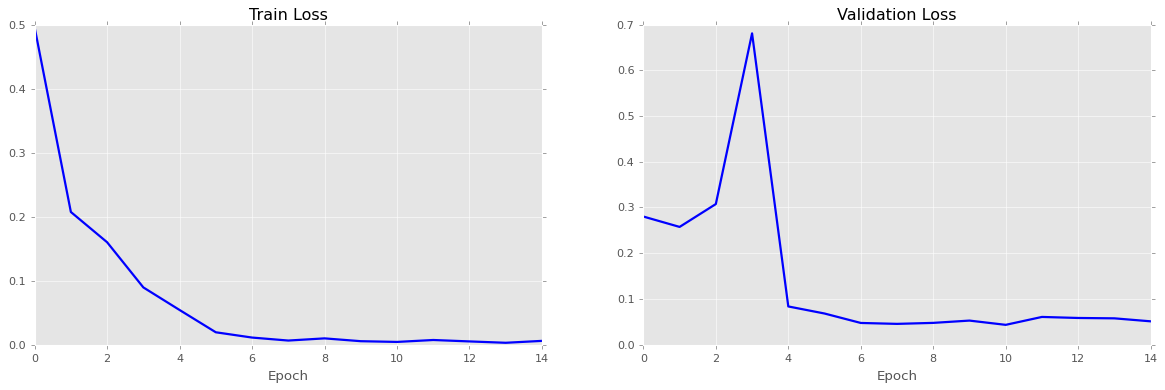

In [ ]:
plt.style.use("ggplot")

## Plot
plt.figure(figsize = (18, 5))

plt.subplot(121)
plt.plot(train_loss_eff, color = "blue", linewidth = 2)
plt.title("Train Loss")
plt.xlabel("Epoch")

plt.subplot(122)
plt.plot(val_loss_eff, color = "blue", linewidth = 2)
plt.title("Validation Loss")
plt.xlabel("Epoch")

plt.show()

In [ ]:
## Combine the F1 score

## Training F1 Score
c1  = train_f1_eff[0].tolist()
c2  = train_f1_eff[1].tolist()
c3  = train_f1_eff[2].tolist()
c4  = train_f1_eff[3].tolist()
c5  = train_f1_eff[4].tolist()
c6  = train_f1_eff[5].tolist()
c7  = train_f1_eff[6].tolist()
c8  = train_f1_eff[7].tolist()
c9  = train_f1_eff[8].tolist()
c11 = train_f1_eff[9].tolist()
c10 = train_f1_eff[10].tolist()
c11 = train_f1_eff[11].tolist()
c12 = train_f1_eff[12].tolist()
c13 = train_f1_eff[13].tolist()
c14 = train_f1_eff[14].tolist()

## Validation F1 Score
v1  = val_f1_eff[0].tolist()
v2  = val_f1_eff[1].tolist()
v3  = val_f1_eff[2].tolist()
v4  = val_f1_eff[3].tolist()
v5  = val_f1_eff[4].tolist()
v6  = val_f1_eff[5].tolist()
v7  = val_f1_eff[6].tolist()
v8  = val_f1_eff[7].tolist()
v9  = val_f1_eff[8].tolist()
v10 = val_f1_eff[9].tolist()
v11 = val_f1_eff[10].tolist()
v12 = val_f1_eff[11].tolist()
v13 = val_f1_eff[12].tolist()
v14 = val_f1_eff[13].tolist()
v15 = val_f1_eff[14].tolist()

In [ ]:
## Organize F1 Score
train_f1_eff_combined = pd.DataFrame([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15])
val_f1_eff_combined   = pd.DataFrame([v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11, v12, v13, v14, v15])

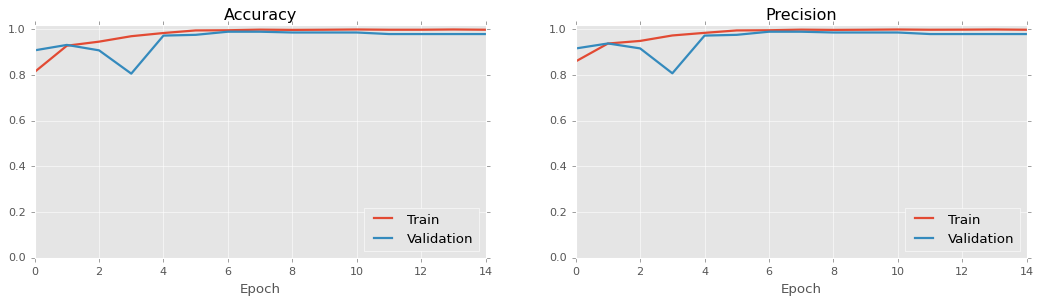

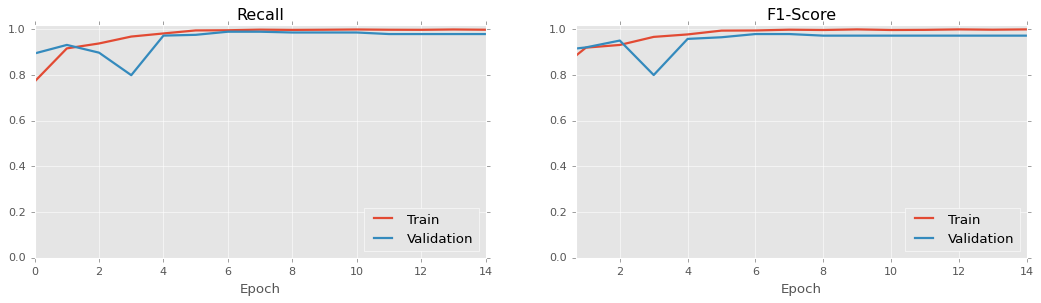

In [ ]:
plt.figure(figsize = (16, 8))

## Performance metrics
## Accuracy Plot
plt.subplot(221)
plt.plot(train_accuracy_eff, label = "Train", linewidth = 2)
plt.plot(val_accuracy_eff, label =  "Validation", linewidth = 2)
plt.ylim(0, 1.02)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")

## Precision Plot
plt.subplot(222)
plt.plot(train_precision_eff, label = "Train", linewidth = 2)
plt.plot(val_precision_eff, label = "Validation", linewidth = 2)
plt.ylim(0, 1.02)
plt.title("Precision")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")
plt.show()

plt.figure(figsize = (16, 8))
## Recall Plot
plt.subplot(223)
plt.plot(train_recall_eff, label = "Train", linewidth = 2)
plt.plot(val_recall_eff, label = "Validation", linewidth = 2)
plt.ylim(0, 1.02)
plt.title("Recall")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")

## F1-Score Plot
plt.subplot(224)
plt.plot(train_f1_eff_combined[0].tolist(), label = "Train", linewidth = 2)
plt.plot(val_f1_eff_combined[0].tolist(), label = "Validation", linewidth = 2)
plt.xlim(0.7)
plt.ylim(0, 1.02)
plt.title("F1-Score")
plt.xlabel("Epoch")
plt.legend(loc = "lower right")

plt.show()

A questo punto, viene utilizzato il miglior modello per generare previsioni sul test set.

* 0 - Glioma Tumor
* 1 - No Tumor
* 2 - Meningioma Tumor
* 3 - Pituitary Tumor

In [ ]:
## Load model
model_eff = load_model("effnet.h5")
## Summarize model
model_eff.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 150, 150, 3)  0           ['normalization[0][0]']    

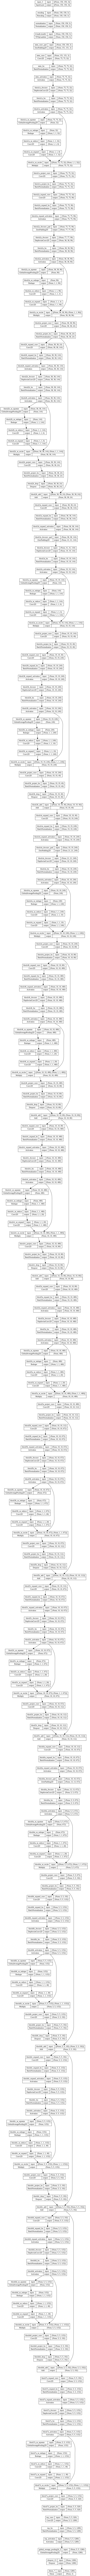

In [ ]:
## Visualize the architecture
plot_model(model_eff, to_file = "Model_EFF_Plot.png", show_shapes = True, show_layer_names = True)

In [ ]:
## Predict
start = timeit.default_timer()

pred_eff   = model_eff.predict(X_test)
y_pred_eff = np.argmax(pred_eff, axis = 1)

stop = timeit.default_timer()
print("Computational Time for predictions with Efficient Net B0:", stop - start)

11/11 [==============================] - 2s 72ms/step
Computational Time for predictions with Efficient Net B0: 2.132660827000109


In [ ]:
## Confusion Matrix
print(classification_report(y_test_new, y_pred_eff))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       102
           1       0.96      1.00      0.98        54
           2       0.97      0.94      0.95        94
           3       1.00      0.99      0.99        77

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



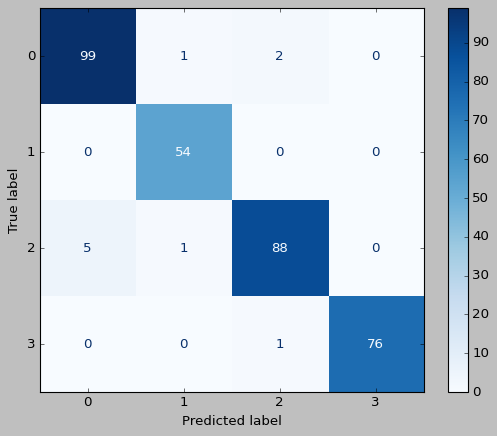

In [ ]:
plt.style.use("classic")

## Confusion Matrix Plot
cm_eff      = confusion_matrix(y_test_new, y_pred_eff)
cm_eff_plot = ConfusionMatrixDisplay(cm_eff)
cm_eff_plot.plot(values_format = "g", cmap = "Blues")

### Conclusioni
Questo studio rappresenta solo uno dei possibili approcci a questo tipo di problema. Come si è visto, non sempre utilizzare una rete pre-trained garantisce delle performance migliori rispetto ad una rete implementata da zero ed i risultati ottenuti dipendono strettamente dalle operazioni di pre-processing effettuate. Infatti, per lavori futuri si potrebbero applicare altre tecniche di pre-processing come cropping dell'immagine, ovvero una tecnica che permette di modificare l'immagine rimuovendo una porzione che non è ritenuta utile e focalizzare l'attenzione sulla parte dell'immagine che si vuole classificare.

Un altro miglioramento potrebbe essere quello di effettuare *object detection*, ovvero rilevare la posizione effettiva del tumore con riquadri di delimitazione utilizzando la segmentazione e sofisticati algoritmi di rilevamento come YOLO (You Only Look Once) e SSD (Single-Shot Detector).

In conclusione, studi futuri in questo ambito possono portare a risultati migliori, possibilmente utilizzando altri metodi di pre-elaborazione e perfezionando ulteriormente gli iperparametri del modello.